#Client: ABC Tech | Category: ITSM - ML Project Ref: PM-PR-0012

#Business Case:


---


ABC Tech is an mid-size organisation operation in IT-enabled business
segment over a decade. On an average ABC Tech receives 22-25k IT
incidents/tickets , which were handled to best practice ITIL framework
with incident management , problem management, change management
and configuration management processes. These ITIL practices attained
matured process level and a recent audit confirmed that further
improvement initiatives may not yield return of investment.



---


ABC Tech management is looking for ways to improve the incident
management process as recent customer survey results shows that
incident management is rated as poor.
Machine Learning as way to improve ITSM processes
ABC Tech management recently attended Machine Learning conference on
ML for ITSM.
Machine learning looks prospective to improve ITSM processes through
prediction and automation. They came up with 4 key areas, where ML can
help ITSM process in ABC Tech.
1. Predicting High Priority Tickets: To predict priority 1 & 2 tickets, so
that they can take preventive measures or fix the problem before
it surfaces.
2. Forecast the incident volume in different fields , quarterly and
annual. So that they can be better prepared with resources and
technology planning.
3. Auto tag the tickets with right priorities and right departments so
that reassigning and related delay can be reduced.
4. Predict RFC (Request for change) and possible failure /
misconfiguration of ITSM assets.

## importing libraries

In [212]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
import joblib

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

##model creation
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA


#model evaluation
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay,f1_score,recall_score,accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
#connecting to the data base
connection = mysql.connector.connect(
    host="18.136.157.135",
    user="dm_team",
    password="DM!$Team@&27920!",
    database="project_itsm"
)

In [3]:
query = 'select * from dataset_list'
df=pd.read_sql(query,connection)

## Basic Checks 

In [4]:
df= df.replace('',pd.NA)

In [5]:
pd.set_option('display.max_columns',None)

In [6]:
df.head()

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change
0,SUB000508,subapplication,Web Based Application,WBS000162,IM0000004,Closed,4,4,4,0.601292279,incident,KM0000553,closed,26,05-02-2012 13:32,<NA>,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007,2,<NA>,<NA>
1,WBA000124,application,Web Based Application,WBS000088,IM0000005,Closed,3,3,3,0.415049969,incident,KM0000611,closed,33,12-03-2012 15:44,02-12-2013 12:31,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011,1,<NA>,<NA>
2,DTA000024,application,Desktop Application,WBS000092,IM0000006,Closed,NS,3,NA,0.517551335,request for information,KM0000339,closed,3,29-03-2012 12:36,<NA>,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017,<NA>,<NA>,<NA>
3,WBA000124,application,Web Based Application,WBS000088,IM0000011,Closed,4,4,4,0.642927218,incident,KM0000611,closed,13,17-07-2012 11:49,<NA>,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025,<NA>,<NA>,<NA>
4,WBA000124,application,Web Based Application,WBS000088,IM0000012,Closed,4,4,4,0.345258343,incident,KM0000611,closed,2,10-08-2012 11:01,<NA>,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029,<NA>,<NA>,<NA>


In [7]:
exclude_columns =['CI_Name','CI_Subcat','WBS','Incident_ID','number_cnt','KB_number','Open_Time','Reopen_Time','Resolved_Time',
      'Close_Time','Handle_Time_hrs','Related_Interaction','No_of_Related_Incidents','No_of_Related_Changes','Related_Change']
print(len([column for column in df.columns if column not in exclude_columns]))
print('\n')
print([column for column in df.columns if column not in exclude_columns])

10


['CI_Cat', 'Status', 'Impact', 'Urgency', 'Priority', 'Category', 'Alert_Status', 'No_of_Reassignments', 'Closure_Code', 'No_of_Related_Interactions']


## EDA

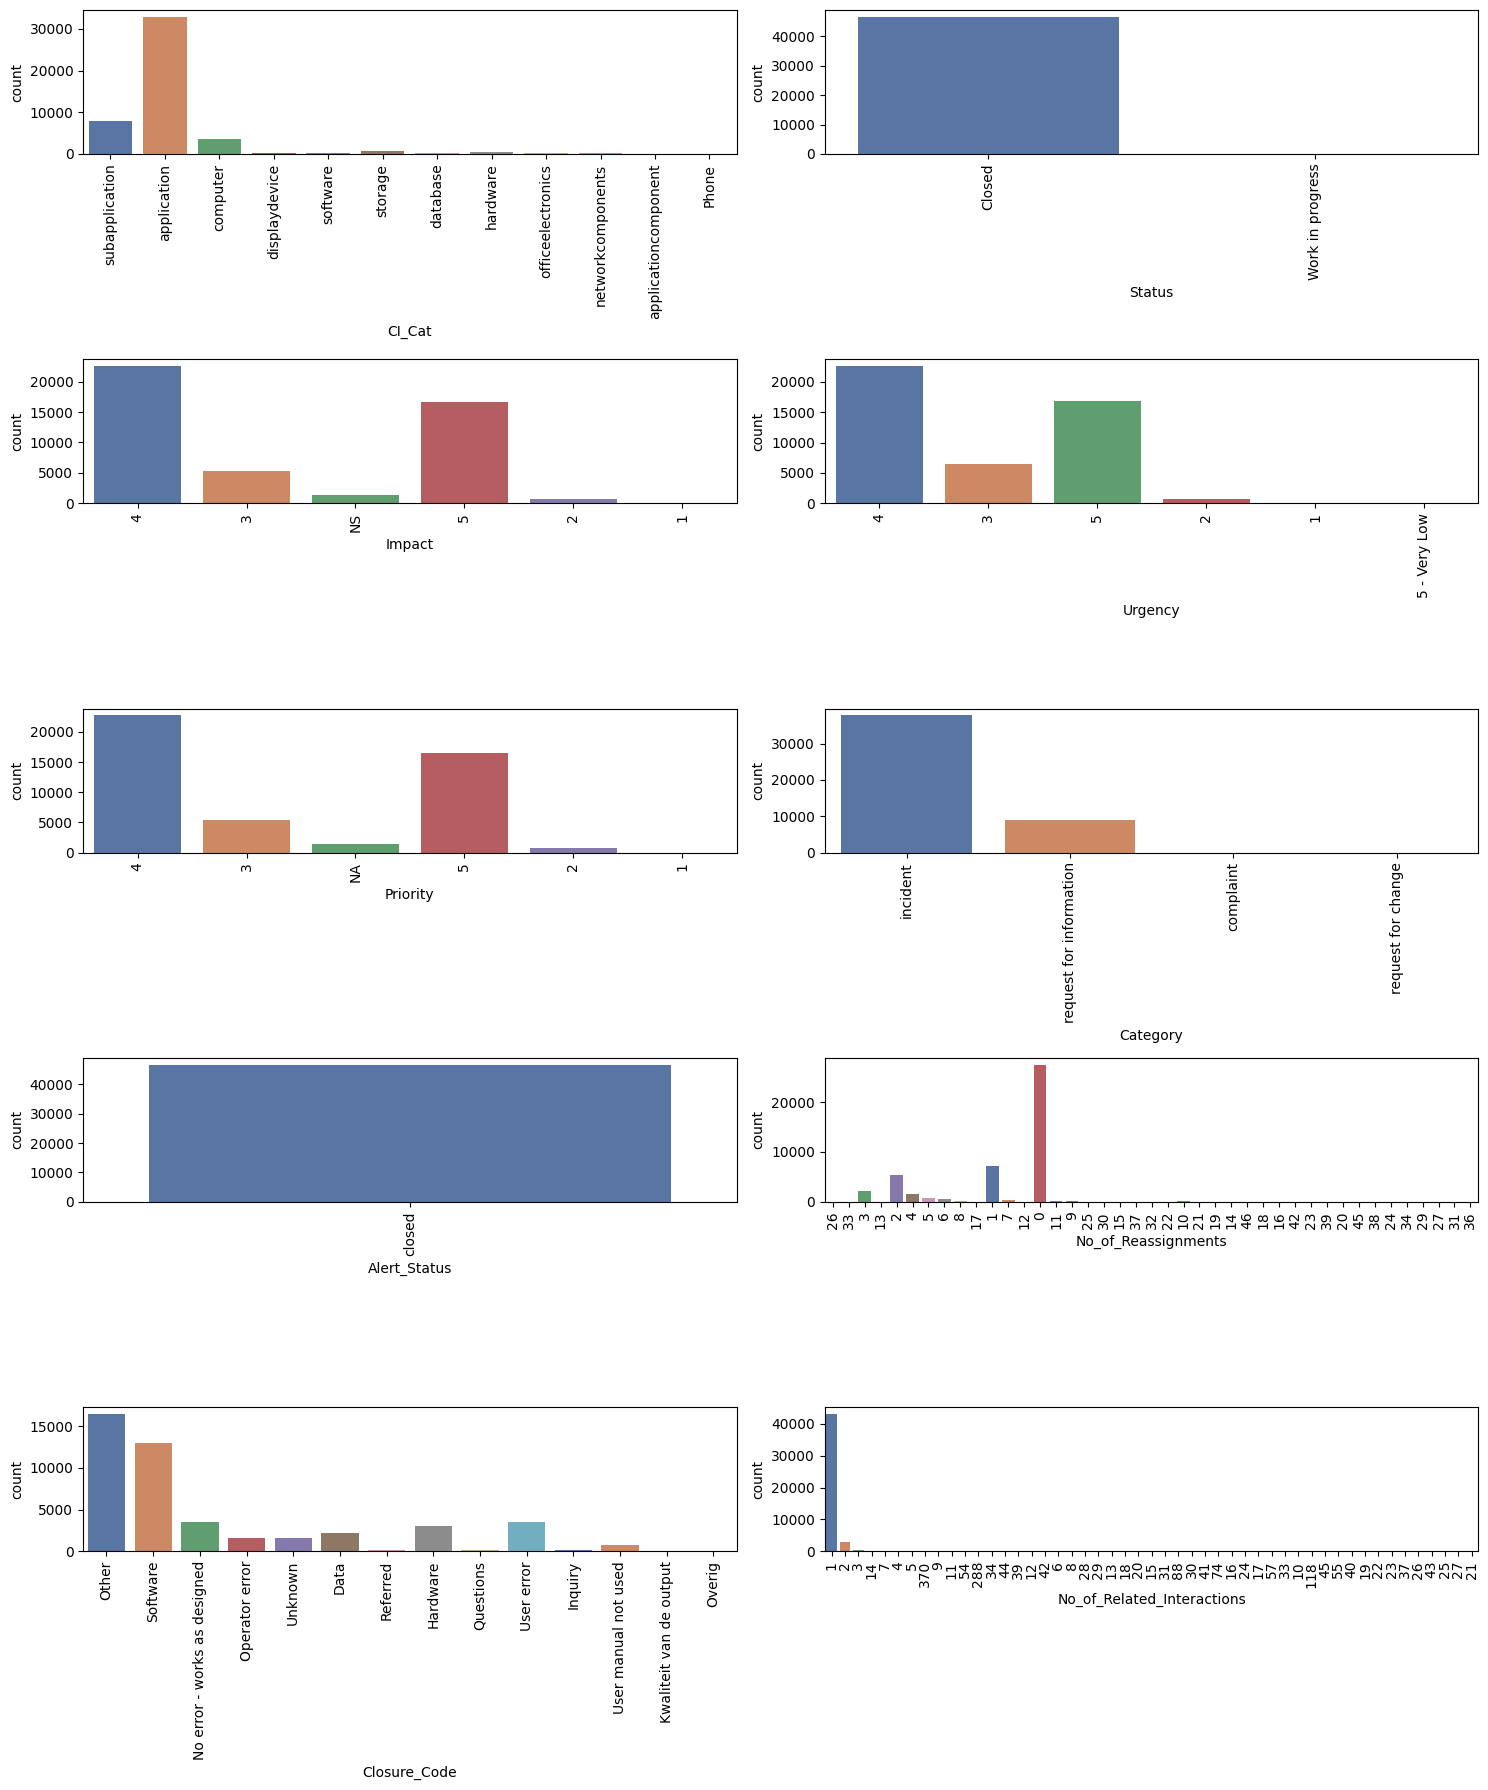

In [8]:
pltno=1
plt.figure(figsize=(15,18))
for i in [column for column in df.columns if column not in exclude_columns]:
    plt.subplot(5,2,pltno)
    sns.countplot(x=i,data=df,palette='deep')
    plt.xlabel(i)
    plt.xticks(rotation=90)
    pltno+= 1
plt.tight_layout()


##Insight-1
---


* in `CI_cat`, that is in the department section of the dataset, it is found that the `application` is having more count compared to others
* The `Status` of almost all of tickets is in closed state
* In the `impact`,`urgency` and `priorty` columns most of the tickets are having imapct and urgency of either 4 or 5
* and the most of the tickets are belonging to the `incident` category
* `No_of_Reassignments` column indicating that most of the tickets solved at `first assignment` and also `some entries are there having reassigned many times`
* `others` and `software` were indicated as the major closure code after the tikcet resloving


---



In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46606 entries, 0 to 46605
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   CI_Name                     46606 non-null  object
 1   CI_Cat                      46495 non-null  object
 2   CI_Subcat                   46495 non-null  object
 3   WBS                         46606 non-null  object
 4   Incident_ID                 46606 non-null  object
 5   Status                      46606 non-null  object
 6   Impact                      46606 non-null  object
 7   Urgency                     46606 non-null  object
 8   Priority                    46606 non-null  object
 9   number_cnt                  46606 non-null  object
 10  Category                    46606 non-null  object
 11  KB_number                   46606 non-null  object
 12  Alert_Status                46606 non-null  object
 13  No_of_Reassignments         46605 non-null  ob

In [10]:
null_df=pd.DataFrame((df.isnull().sum()/len(df))*100,columns=['per'])
null_df['count']=df.isnull().sum()
null_df

,per,count
CI_Name,0.000000,0
CI_Cat,0.238167,111
CI_Subcat,0.238167,111
WBS,0.000000,0
Incident_ID,0.000000,0
Status,0.000000,0
Impact,0.000000,0
Urgency,0.000000,0
Priority,0.000000,0
number_cnt,0.000000,0


**droppping the `columns which are above 50% `null values**


In [11]:
null_df[null_df['per']>50]

,per,count
Reopen_Time,95.099343,44322
No_of_Related_Incidents,97.378020,45384
No_of_Related_Changes,98.798438,46046
Related_Change,98.798438,46046


* dropping all except **No_of_Related_Incidents** & **No_of_Related_Changes** as it required for Task 4 

In [12]:
df.drop('Reopen_Time', axis=1, inplace=True)

In [13]:
df['No_of_Related_Incidents'].value_counts()

1     1057
2       74
3       20
4       13
5        8
6        8
9        6
8        5
11       4
12       4
7        4
17       3
16       3
10       2
24       2
14       1
25       1
23       1
54       1
26       1
21       1
63       1
13       1
15       1
Name: No_of_Related_Incidents, dtype: int64

In [19]:
df.No_of_Related_Incidents.replace(np.nan,0,inplace=True)

In [18]:
df['No_of_Related_Incidents'].dtype

dtype('O')

In [21]:
df['No_of_Related_Incidents']=df['No_of_Related_Incidents'].astype(int)

In [22]:
df.drop('Related_Change', axis=1, inplace=True)

In [23]:
df.No_of_Related_Changes.replace(np.nan,0,inplace=True)

In [24]:
df['No_of_Related_Changes'].dtype

dtype('O')

In [25]:
df['No_of_Related_Changes']=df['No_of_Related_Changes'].astype(int)

In [26]:
df.head()

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes
0,SUB000508,subapplication,Web Based Application,WBS000162,IM0000004,Closed,4,4,4,0.601292279,incident,KM0000553,closed,26,05-02-2012 13:32,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007,2,0
1,WBA000124,application,Web Based Application,WBS000088,IM0000005,Closed,3,3,3,0.415049969,incident,KM0000611,closed,33,12-03-2012 15:44,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011,1,0
2,DTA000024,application,Desktop Application,WBS000092,IM0000006,Closed,NS,3,NA,0.517551335,request for information,KM0000339,closed,3,29-03-2012 12:36,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017,0,0
3,WBA000124,application,Web Based Application,WBS000088,IM0000011,Closed,4,4,4,0.642927218,incident,KM0000611,closed,13,17-07-2012 11:49,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025,0,0
4,WBA000124,application,Web Based Application,WBS000088,IM0000012,Closed,4,4,4,0.345258343,incident,KM0000611,closed,2,10-08-2012 11:01,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029,0,0


In [27]:
for i in df.columns:
    if df[i].dtype=='object':
        print(f'{i} {len(df[i].unique())}')
        print('------'*5)

CI_Name 3019
------------------------------
CI_Cat 13
------------------------------
CI_Subcat 65
------------------------------
WBS 274
------------------------------
Incident_ID 46606
------------------------------
Status 2
------------------------------
Impact 6
------------------------------
Urgency 6
------------------------------
Priority 6
------------------------------
number_cnt 46606
------------------------------
Category 4
------------------------------
KB_number 1825
------------------------------
Alert_Status 1
------------------------------
No_of_Reassignments 42
------------------------------
Open_Time 34636
------------------------------
Resolved_Time 33628
------------------------------
Close_Time 34528
------------------------------
Handle_Time_hrs 30639
------------------------------
Closure_Code 15
------------------------------
No_of_Related_Interactions 50
------------------------------
Related_Interaction 43060
------------------------------


#check for unique values

---



checking all the unique values of categorical columns

fixing the number 66 after knowing the maximum length of discrete columns


---


In [28]:
for i in df.columns:
    if df[i].dtype=='object':
        if len(df[i].unique())<66:
            print(f'{i} -----> {df[i].unique()}')
            print('----'*10)

CI_Cat -----> ['subapplication' 'application' 'computer' <NA> 'displaydevice' 'software'
 'storage' 'database' 'hardware' 'officeelectronics' 'networkcomponents'
 'applicationcomponent' 'Phone']
----------------------------------------
CI_Subcat -----> ['Web Based Application' 'Desktop Application' 'Server Based Application'
 'SAP' 'Client Based Application' 'Citrix' 'Standard Application'
 'Windows Server' 'Laptop' 'Linux Server' <NA> 'Monitor'
 'Automation Software' 'SAN' 'Banking Device' 'Desktop' 'Database'
 'Oracle Server' 'Keyboard' 'Printer' 'Exchange' 'System Software' 'VDI'
 'Encryption' 'Omgeving' 'MigratieDummy' 'Scanner' 'Controller'
 'DataCenterEquipment' 'KVM Switches' 'Switch' 'Database Software'
 'Network Component' 'Unix Server' 'Lines' 'ESX Cluster' 'zOS Server'
 'SharePoint Farm' 'NonStop Server' 'Application Server'
 'Security Software' 'Thin Client' 'zOS Cluster' 'Router' 'VMWare'
 'Net Device' 'Neoview Server' 'MQ Queue Manager' 'UPS' 'Number'
 'Iptelephony' 'Wind

# data preprocessing column by column



---


* ML algorithms will work well if first undertood the data well, so im doing this way to understand the data well to preprocess the well

* preprocessing the data column by column for better cleaning of data

* in the preprocessing the stages follwing these steps
    1. null value imputation
    2. label encoding
    3. force typecating
    4. dropping the unnessesory columns

    and other required preprocessing steps


---



---


## df['CI_Name']

*  as name doesnot impact on ticket priority dropping the name column

In [29]:
df.drop('CI_Name',axis=1,inplace=True)

In [30]:
df.head()

,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes
0,subapplication,Web Based Application,WBS000162,IM0000004,Closed,4,4,4,0.601292279,incident,KM0000553,closed,26,05-02-2012 13:32,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007,2,0
1,application,Web Based Application,WBS000088,IM0000005,Closed,3,3,3,0.415049969,incident,KM0000611,closed,33,12-03-2012 15:44,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011,1,0
2,application,Desktop Application,WBS000092,IM0000006,Closed,NS,3,NA,0.517551335,request for information,KM0000339,closed,3,29-03-2012 12:36,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017,0,0
3,application,Web Based Application,WBS000088,IM0000011,Closed,4,4,4,0.642927218,incident,KM0000611,closed,13,17-07-2012 11:49,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025,0,0
4,application,Web Based Application,WBS000088,IM0000012,Closed,4,4,4,0.345258343,incident,KM0000611,closed,2,10-08-2012 11:01,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029,0,0


## df['CI_Cat']

In [31]:
df['CI_Cat'].value_counts()

application             32900
subapplication           7782
computer                 3643
storage                   703
hardware                  442
software                  333
database                  214
displaydevice             212
officeelectronics         152
networkcomponents         107
applicationcomponent        5
Phone                       2
Name: CI_Cat, dtype: int64

In [32]:
df['CI_Cat'].isnull().sum()

111

In [33]:
df.loc[df['CI_Cat'].isnull(),'CI_Cat']= 'application'

In [34]:
df['CI_Cat'].value_counts()

application             33011
subapplication           7782
computer                 3643
storage                   703
hardware                  442
software                  333
database                  214
displaydevice             212
officeelectronics         152
networkcomponents         107
applicationcomponent        5
Phone                       2
Name: CI_Cat, dtype: int64

*  transforming the columns from categorical columns to numerical columns using `label_encoder`

In [35]:
encoder=LabelEncoder()
df['CI_Cat']= encoder.fit_transform(df['CI_Cat'])

In [36]:
df['CI_Cat']

0        11
1         1
2         1
3         1
4         1
         ..
46601     1
46602     1
46603     3
46604     1
46605     6
Name: CI_Cat, Length: 46606, dtype: int32

In [37]:
df.head()

,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes
0,11,Web Based Application,WBS000162,IM0000004,Closed,4,4,4,0.601292279,incident,KM0000553,closed,26,05-02-2012 13:32,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007,2,0
1,1,Web Based Application,WBS000088,IM0000005,Closed,3,3,3,0.415049969,incident,KM0000611,closed,33,12-03-2012 15:44,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011,1,0
2,1,Desktop Application,WBS000092,IM0000006,Closed,NS,3,NA,0.517551335,request for information,KM0000339,closed,3,29-03-2012 12:36,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017,0,0
3,1,Web Based Application,WBS000088,IM0000011,Closed,4,4,4,0.642927218,incident,KM0000611,closed,13,17-07-2012 11:49,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025,0,0
4,1,Web Based Application,WBS000088,IM0000012,Closed,4,4,4,0.345258343,incident,KM0000611,closed,2,10-08-2012 11:01,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029,0,0


## df['CI_Subcat']

In [38]:
df['CI_Subcat'].unique()

array(['Web Based Application', 'Desktop Application',
       'Server Based Application', 'SAP', 'Client Based Application',
       'Citrix', 'Standard Application', 'Windows Server', 'Laptop',
       'Linux Server', <NA>, 'Monitor', 'Automation Software', 'SAN',
       'Banking Device', 'Desktop', 'Database', 'Oracle Server',
       'Keyboard', 'Printer', 'Exchange', 'System Software', 'VDI',
       'Encryption', 'Omgeving', 'MigratieDummy', 'Scanner', 'Controller',
       'DataCenterEquipment', 'KVM Switches', 'Switch',
       'Database Software', 'Network Component', 'Unix Server', 'Lines',
       'ESX Cluster', 'zOS Server', 'SharePoint Farm', 'NonStop Server',
       'Application Server', 'Security Software', 'Thin Client',
       'zOS Cluster', 'Router', 'VMWare', 'Net Device', 'Neoview Server',
       'MQ Queue Manager', 'UPS', 'Number', 'Iptelephony',
       'Windows Server in extern beheer', 'Modem', 'X86 Server',
       'ESX Server', 'Virtual Tape Server', 'IPtelephony',
    

In [39]:
df['CI_Subcat'].isnull().sum()

111

In [40]:
df['CI_Subcat'].mode()

0    Server Based Application
Name: CI_Subcat, dtype: object

*  there were 111 null values present this columns replacing those with mode i.e. `server based application`

In [41]:
df.loc[df['CI_Subcat'].isnull(),'CI_Subcat']=df['CI_Subcat'].mode()[0]

In [42]:
df['CI_Subcat'].isnull().sum()

0

* transforming the columns from categorical columns to numerical columns using `label_encoder`

In [43]:
df['CI_Subcat']=encoder.fit_transform(df['CI_Subcat'])

In [44]:
df.head()

,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes
0,11,57,WBS000162,IM0000004,Closed,4,4,4,0.601292279,incident,KM0000553,closed,26,05-02-2012 13:32,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007,2,0
1,1,57,WBS000088,IM0000005,Closed,3,3,3,0.415049969,incident,KM0000611,closed,33,12-03-2012 15:44,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011,1,0
2,1,10,WBS000092,IM0000006,Closed,NS,3,NA,0.517551335,request for information,KM0000339,closed,3,29-03-2012 12:36,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017,0,0
3,1,57,WBS000088,IM0000011,Closed,4,4,4,0.642927218,incident,KM0000611,closed,13,17-07-2012 11:49,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025,0,0
4,1,57,WBS000088,IM0000012,Closed,4,4,4,0.345258343,incident,KM0000611,closed,2,10-08-2012 11:01,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029,0,0


## df['WBS']

In [45]:
len(df['WBS'].unique())

274

* extracting the unique numbers of the WBS system

In [46]:
df['WBS']=df['WBS'].apply(lambda x: x[-3:])

In [47]:
df['WBS']

0        162
1        088
2        092
3        088
4        088
        ... 
46601    073
46602    073
46603    091
46604    073
46605    267
Name: WBS, Length: 46606, dtype: object

In [48]:
df['WBS']=df['WBS'].astype(int)

In [49]:
df.head()

,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes
0,11,57,162,IM0000004,Closed,4,4,4,0.601292279,incident,KM0000553,closed,26,05-02-2012 13:32,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007,2,0
1,1,57,88,IM0000005,Closed,3,3,3,0.415049969,incident,KM0000611,closed,33,12-03-2012 15:44,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011,1,0
2,1,10,92,IM0000006,Closed,NS,3,NA,0.517551335,request for information,KM0000339,closed,3,29-03-2012 12:36,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017,0,0
3,1,57,88,IM0000011,Closed,4,4,4,0.642927218,incident,KM0000611,closed,13,17-07-2012 11:49,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025,0,0
4,1,57,88,IM0000012,Closed,4,4,4,0.345258343,incident,KM0000611,closed,2,10-08-2012 11:01,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029,0,0


## df['Incident_ID']

In [50]:
len(df['Incident_ID'].unique())

46606

* there are `46606` unique values in this column and it carries no weight to data  so dropping the column

In [51]:
df.drop('Incident_ID',axis=1,inplace=True)

In [52]:
df.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes
0,11,57,162,Closed,4,4,4,0.601292279,incident,KM0000553,closed,26,05-02-2012 13:32,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007,2,0
1,1,57,88,Closed,3,3,3,0.415049969,incident,KM0000611,closed,33,12-03-2012 15:44,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011,1,0
2,1,10,92,Closed,NS,3,NA,0.517551335,request for information,KM0000339,closed,3,29-03-2012 12:36,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017,0,0
3,1,57,88,Closed,4,4,4,0.642927218,incident,KM0000611,closed,13,17-07-2012 11:49,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025,0,0
4,1,57,88,Closed,4,4,4,0.345258343,incident,KM0000611,closed,2,10-08-2012 11:01,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029,0,0


## df['Status']

In [53]:
df['Status'].unique()

array(['Closed', 'Work in progress'], dtype=object)

* using label encoder to convert the categorical columns to numerical columns


In [54]:
df['Status'].isnull().sum()

0

In [55]:
df['Status']=encoder.fit_transform(df['Status'])

In [56]:
df.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes
0,11,57,162,0,4,4,4,0.601292279,incident,KM0000553,closed,26,05-02-2012 13:32,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007,2,0
1,1,57,88,0,3,3,3,0.415049969,incident,KM0000611,closed,33,12-03-2012 15:44,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011,1,0
2,1,10,92,0,NS,3,NA,0.517551335,request for information,KM0000339,closed,3,29-03-2012 12:36,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017,0,0
3,1,57,88,0,4,4,4,0.642927218,incident,KM0000611,closed,13,17-07-2012 11:49,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025,0,0
4,1,57,88,0,4,4,4,0.345258343,incident,KM0000611,closed,2,10-08-2012 11:01,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029,0,0


## df['Impact']

In [57]:
df['Impact'].value_counts()

4     22556
5     16741
3      5234
NS     1380
2       692
1         3
Name: Impact, dtype: int64

In [58]:
df['Impact'].mode()[0]

'4'

*  replacing the null values with mode of the column i.e 4

In [59]:
df.loc[df['Impact']=='NS','Impact']=df['Impact'].mode()[0]

In [60]:
df.loc[df['Impact']=='NS']

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes


In [61]:
df['Impact'].dtype

dtype('O')

In [62]:
df['Impact']=df['Impact'].astype(int)

In [63]:
df['Impact'].unique()

array([4, 3, 5, 2, 1])

## df['Urgency']

In [64]:
df['Urgency'].value_counts()

4               22588
5               16779
3                6536
2                 696
1                   6
5 - Very Low        1
Name: Urgency, dtype: int64

* urgency level 5 -very low  as only 1 entry there in data dropping the column

In [65]:
df.drop(df.loc[df['Urgency']=='5 - Very Low'].index,axis=0,inplace=True)

In [66]:
df['Urgency'].value_counts()

4    22588
5    16779
3     6536
2      696
1        6
Name: Urgency, dtype: int64

In [67]:
df['Urgency']=df['Urgency'].astype(int)

In [68]:
df['Urgency'].unique()

array([4, 3, 5, 2, 1])

In [69]:
df.shape

(46605, 21)

In [70]:
df.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes
0,11,57,162,0,4,4,4,0.601292279,incident,KM0000553,closed,26,05-02-2012 13:32,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007,2,0
1,1,57,88,0,3,3,3,0.415049969,incident,KM0000611,closed,33,12-03-2012 15:44,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011,1,0
2,1,10,92,0,4,3,NA,0.517551335,request for information,KM0000339,closed,3,29-03-2012 12:36,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017,0,0
3,1,57,88,0,4,4,4,0.642927218,incident,KM0000611,closed,13,17-07-2012 11:49,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025,0,0
4,1,57,88,0,4,4,4,0.345258343,incident,KM0000611,closed,2,10-08-2012 11:01,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029,0,0


## df['Priority']

In [71]:
df['Priority'].unique()

array(['4', '3', 'NA', '5', '2', '1'], dtype=object)

In [72]:
df['Priority'].value_counts()

4     22717
5     16485
3      5323
NA     1380
2       697
1         3
Name: Priority, dtype: int64

In [73]:
df['Priority'].mode()

0    4
Name: Priority, dtype: object

In [74]:
df.loc[df['Priority']=='NA','Priority']=df['Priority'].mode()[0]

In [75]:
df['Priority']=df['Priority'].astype(int)

In [76]:
df.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes
0,11,57,162,0,4,4,4,0.601292279,incident,KM0000553,closed,26,05-02-2012 13:32,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007,2,0
1,1,57,88,0,3,3,3,0.415049969,incident,KM0000611,closed,33,12-03-2012 15:44,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011,1,0
2,1,10,92,0,4,3,4,0.517551335,request for information,KM0000339,closed,3,29-03-2012 12:36,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017,0,0
3,1,57,88,0,4,4,4,0.642927218,incident,KM0000611,closed,13,17-07-2012 11:49,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025,0,0
4,1,57,88,0,4,4,4,0.345258343,incident,KM0000611,closed,2,10-08-2012 11:01,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029,0,0


## df['number_cnt']

In [77]:
df['number_cnt']=df['number_cnt'].astype(float)

## df['Category']

In [78]:
df['Category'].unique()

array(['incident', 'request for information', 'complaint',
       'request for change'], dtype=object)

*  transforming the catergorical columns to numerical columns

In [79]:
df['Category']=encoder.fit_transform(df['Category'])

In [80]:
df.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes
0,11,57,162,0,4,4,4,0.601292,1,KM0000553,closed,26,05-02-2012 13:32,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007,2,0
1,1,57,88,0,3,3,3,0.415050,1,KM0000611,closed,33,12-03-2012 15:44,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011,1,0
2,1,10,92,0,4,3,4,0.517551,3,KM0000339,closed,3,29-03-2012 12:36,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017,0,0
3,1,57,88,0,4,4,4,0.642927,1,KM0000611,closed,13,17-07-2012 11:49,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025,0,0
4,1,57,88,0,4,4,4,0.345258,1,KM0000611,closed,2,10-08-2012 11:01,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029,0,0


## df['KB_number']

In [81]:
len(df['KB_number'].unique())

1824

*  extracting the last 4 numbers of column

In [82]:
df['KB_number']=df['KB_number'].apply(lambda x: x[-4:])

In [83]:
df['KB_number']=df['KB_number'].astype(int)

In [84]:
df.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes
0,11,57,162,0,4,4,4,0.601292,1,553,closed,26,05-02-2012 13:32,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007,2,0
1,1,57,88,0,3,3,3,0.415050,1,611,closed,33,12-03-2012 15:44,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011,1,0
2,1,10,92,0,4,3,4,0.517551,3,339,closed,3,29-03-2012 12:36,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017,0,0
3,1,57,88,0,4,4,4,0.642927,1,611,closed,13,17-07-2012 11:49,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025,0,0
4,1,57,88,0,4,4,4,0.345258,1,611,closed,2,10-08-2012 11:01,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029,0,0


## df['Alert_Status']

In [85]:
df['Alert_Status'].unique()

array(['closed'], dtype=object)

In [86]:
df['Alert_Status'].value_counts()

closed    46605
Name: Alert_Status, dtype: int64

*  as almost all the columns are in `closed` state dropping the columns

In [87]:
df.drop('Alert_Status',axis=1,inplace=True)

In [88]:
df.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes
0,11,57,162,0,4,4,4,0.601292,1,553,26,05-02-2012 13:32,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007,2,0
1,1,57,88,0,3,3,3,0.415050,1,611,33,12-03-2012 15:44,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011,1,0
2,1,10,92,0,4,3,4,0.517551,3,339,3,29-03-2012 12:36,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017,0,0
3,1,57,88,0,4,4,4,0.642927,1,611,13,17-07-2012 11:49,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025,0,0
4,1,57,88,0,4,4,4,0.345258,1,611,2,10-08-2012 11:01,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029,0,0


## df['No_of_Reassignments']

In [89]:
len(df['No_of_Reassignments'].unique())

42

In [90]:
df['No_of_Reassignments'].mode()

0    0
Name: No_of_Reassignments, dtype: object

In [91]:
df['No_of_Reassignments'].isnull().sum()

1

*  replacing the null values with mode i.e 0

In [92]:
df.loc[df['No_of_Reassignments'].isnull(),'No_of_Reassignments']=df['No_of_Reassignments'].mode()[0]

In [93]:
df['No_of_Reassignments'].isnull().sum()

0

In [94]:
df['No_of_Reassignments']=df['No_of_Reassignments'].astype(int)

In [95]:
df.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes
0,11,57,162,0,4,4,4,0.601292,1,553,26,05-02-2012 13:32,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007,2,0
1,1,57,88,0,3,3,3,0.415050,1,611,33,12-03-2012 15:44,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011,1,0
2,1,10,92,0,4,3,4,0.517551,3,339,3,29-03-2012 12:36,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017,0,0
3,1,57,88,0,4,4,4,0.642927,1,611,13,17-07-2012 11:49,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025,0,0
4,1,57,88,0,4,4,4,0.345258,1,611,2,10-08-2012 11:01,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029,0,0


## df['Open_Time']

In [96]:
df['Open_Time'].isnull().sum()

0

*  converting the open time column to datetime format

In [97]:
df['Open_Time']=pd.to_datetime(df['Open_Time'])

In [98]:
df.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes
0,11,57,162,0,4,4,4,0.601292,1,553,26,2012-05-02 13:32:00,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007,2,0
1,1,57,88,0,3,3,3,0.415050,1,611,33,2012-12-03 15:44:00,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011,1,0
2,1,10,92,0,4,3,4,0.517551,3,339,3,2012-03-29 12:36:00,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017,0,0
3,1,57,88,0,4,4,4,0.642927,1,611,13,2012-07-17 11:49:00,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025,0,0
4,1,57,88,0,4,4,4,0.345258,1,611,2,2012-10-08 11:01:00,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029,0,0


## df['Resolved_Time']

In [99]:
df['Resolved_Time']=pd.to_datetime(df['Resolved_Time'])

In [100]:
df.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes
0,11,57,162,0,4,4,4,0.601292,1,553,26,2012-05-02 13:32:00,2013-04-11 13:50:00,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007,2,0
1,1,57,88,0,3,3,3,0.415050,1,611,33,2012-12-03 15:44:00,2013-02-12 12:36:00,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011,1,0
2,1,10,92,0,4,3,4,0.517551,3,339,3,2012-03-29 12:36:00,2014-01-13 15:12:00,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017,0,0
3,1,57,88,0,4,4,4,0.642927,1,611,13,2012-07-17 11:49:00,2013-11-14 09:31:00,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025,0,0
4,1,57,88,0,4,4,4,0.345258,1,611,2,2012-10-08 11:01:00,2013-08-11 13:55:00,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029,0,0


In [101]:
df['Resolved_Time'].isnull().sum()

1780

In [102]:
df['Resolved_Time'].mode()[0]

Timestamp('2013-10-10 12:53:00')

In [103]:
df.loc[df['Resolved_Time'].isnull(),'Resolved_Time']=df['Resolved_Time'].mode()[0]

In [104]:
df['Resolved_Time'].isnull().sum()

0

In [105]:
df['Resolved_Time']=pd.to_datetime(df['Resolved_Time'])

In [106]:
df.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes
0,11,57,162,0,4,4,4,0.601292,1,553,26,2012-05-02 13:32:00,2013-04-11 13:50:00,04-11-2013 13:51,"3,87,16,91,111",Other,1,SD0000007,2,0
1,1,57,88,0,3,3,3,0.415050,1,611,33,2012-12-03 15:44:00,2013-02-12 12:36:00,02-12-2013 12:36,"4,35,47,86,389",Software,1,SD0000011,1,0
2,1,10,92,0,4,3,4,0.517551,3,339,3,2012-03-29 12:36:00,2014-01-13 15:12:00,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1,SD0000017,0,0
3,1,57,88,0,4,4,4,0.642927,1,611,13,2012-07-17 11:49:00,2013-11-14 09:31:00,14-11-2013 09:31,"4,32,18,33,333",Operator error,1,SD0000025,0,0
4,1,57,88,0,4,4,4,0.345258,1,611,2,2012-10-08 11:01:00,2013-08-11 13:55:00,08-11-2013 13:55,"3,38,39,03,333",Other,1,SD0000029,0,0


## df['Close_Time']

In [107]:
df['Close_Time'].isnull().sum()

0

In [108]:
df['Close_Time']=pd.to_datetime(df['Close_Time'])

In [109]:
df.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes
0,11,57,162,0,4,4,4,0.601292,1,553,26,2012-05-02 13:32:00,2013-04-11 13:50:00,2013-04-11 13:51:00,"3,87,16,91,111",Other,1,SD0000007,2,0
1,1,57,88,0,3,3,3,0.415050,1,611,33,2012-12-03 15:44:00,2013-02-12 12:36:00,2013-02-12 12:36:00,"4,35,47,86,389",Software,1,SD0000011,1,0
2,1,10,92,0,4,3,4,0.517551,3,339,3,2012-03-29 12:36:00,2014-01-13 15:12:00,2014-01-13 15:13:00,"4,84,31,19,444",No error - works as designed,1,SD0000017,0,0
3,1,57,88,0,4,4,4,0.642927,1,611,13,2012-07-17 11:49:00,2013-11-14 09:31:00,2013-11-14 09:31:00,"4,32,18,33,333",Operator error,1,SD0000025,0,0
4,1,57,88,0,4,4,4,0.345258,1,611,2,2012-10-08 11:01:00,2013-08-11 13:55:00,2013-08-11 13:55:00,"3,38,39,03,333",Other,1,SD0000029,0,0


## df['Handle_Time_hrs']

*   manually creating the `handle_time_hrs` as the given `handle_time_hrs` is not carrying any meaningfull information
*  converting the difference days to hours taken

In [110]:
df.drop('Handle_Time_hrs',axis=1,inplace=True)

In [111]:
df['Handle_Time_hrs_conv']=abs(df['Close_Time']-df['Open_Time'])

In [112]:
a=[]
for i in df['Handle_Time_hrs_conv'].index:
    a.append((df['Handle_Time_hrs_conv'][i].total_seconds())/3600)


In [113]:
df['Handle_Time_hrs_conv']=a

In [114]:
df.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Handle_Time_hrs_conv
0,11,57,162,0,4,4,4,0.601292,1,553,26,2012-05-02 13:32:00,2013-04-11 13:50:00,2013-04-11 13:51:00,Other,1,SD0000007,2,0,8256.316667
1,1,57,88,0,3,3,3,0.415050,1,611,33,2012-12-03 15:44:00,2013-02-12 12:36:00,2013-02-12 12:36:00,Software,1,SD0000011,1,0,1700.866667
2,1,10,92,0,4,3,4,0.517551,3,339,3,2012-03-29 12:36:00,2014-01-13 15:12:00,2014-01-13 15:13:00,No error - works as designed,1,SD0000017,0,0,15722.616667
3,1,57,88,0,4,4,4,0.642927,1,611,13,2012-07-17 11:49:00,2013-11-14 09:31:00,2013-11-14 09:31:00,Operator error,1,SD0000025,0,0,11637.700000
4,1,57,88,0,4,4,4,0.345258,1,611,2,2012-10-08 11:01:00,2013-08-11 13:55:00,2013-08-11 13:55:00,Other,1,SD0000029,0,0,7370.900000


## df['Closure_Code']

* as the closure code will not determine the ticket priority and importance as its done at the posterior stage of ticket resolving

In [115]:
df.drop('Closure_Code',axis=1,inplace=True)

In [116]:
df.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Handle_Time_hrs_conv
0,11,57,162,0,4,4,4,0.601292,1,553,26,2012-05-02 13:32:00,2013-04-11 13:50:00,2013-04-11 13:51:00,1,SD0000007,2,0,8256.316667
1,1,57,88,0,3,3,3,0.415050,1,611,33,2012-12-03 15:44:00,2013-02-12 12:36:00,2013-02-12 12:36:00,1,SD0000011,1,0,1700.866667
2,1,10,92,0,4,3,4,0.517551,3,339,3,2012-03-29 12:36:00,2014-01-13 15:12:00,2014-01-13 15:13:00,1,SD0000017,0,0,15722.616667
3,1,57,88,0,4,4,4,0.642927,1,611,13,2012-07-17 11:49:00,2013-11-14 09:31:00,2013-11-14 09:31:00,1,SD0000025,0,0,11637.700000
4,1,57,88,0,4,4,4,0.345258,1,611,2,2012-10-08 11:01:00,2013-08-11 13:55:00,2013-08-11 13:55:00,1,SD0000029,0,0,7370.900000


## df['No_of_Related_Interactions']

In [117]:
df['No_of_Related_Interactions'].isnull().sum()

114

In [118]:
len(df['No_of_Related_Interactions'].unique())

50

In [119]:
df['No_of_Related_Interactions'].mode()

0    1
Name: No_of_Related_Interactions, dtype: object

*  replacing the null values with mode

In [120]:
df.loc[df['No_of_Related_Interactions'].isnull(),'No_of_Related_Interactions']=df['No_of_Related_Interactions'].mode()[0]


In [121]:
df['No_of_Related_Interactions'].isnull().sum()

0

In [122]:
df['No_of_Related_Interactions']=df['No_of_Related_Interactions'].astype(int)

In [123]:
df.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Handle_Time_hrs_conv
0,11,57,162,0,4,4,4,0.601292,1,553,26,2012-05-02 13:32:00,2013-04-11 13:50:00,2013-04-11 13:51:00,1,SD0000007,2,0,8256.316667
1,1,57,88,0,3,3,3,0.415050,1,611,33,2012-12-03 15:44:00,2013-02-12 12:36:00,2013-02-12 12:36:00,1,SD0000011,1,0,1700.866667
2,1,10,92,0,4,3,4,0.517551,3,339,3,2012-03-29 12:36:00,2014-01-13 15:12:00,2014-01-13 15:13:00,1,SD0000017,0,0,15722.616667
3,1,57,88,0,4,4,4,0.642927,1,611,13,2012-07-17 11:49:00,2013-11-14 09:31:00,2013-11-14 09:31:00,1,SD0000025,0,0,11637.700000
4,1,57,88,0,4,4,4,0.345258,1,611,2,2012-10-08 11:01:00,2013-08-11 13:55:00,2013-08-11 13:55:00,1,SD0000029,0,0,7370.900000


## df['Related_Interaction']

In [124]:
len(df['Related_Interaction'].unique())

43059

In [125]:
df.drop('Related_Interaction',axis=1,inplace=True)

## Preprocessed dataset for machine learning

In [126]:
df.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,No_of_Related_Interactions,No_of_Related_Incidents,No_of_Related_Changes,Handle_Time_hrs_conv
0,11,57,162,0,4,4,4,0.601292,1,553,26,2012-05-02 13:32:00,2013-04-11 13:50:00,2013-04-11 13:51:00,1,2,0,8256.316667
1,1,57,88,0,3,3,3,0.415050,1,611,33,2012-12-03 15:44:00,2013-02-12 12:36:00,2013-02-12 12:36:00,1,1,0,1700.866667
2,1,10,92,0,4,3,4,0.517551,3,339,3,2012-03-29 12:36:00,2014-01-13 15:12:00,2014-01-13 15:13:00,1,0,0,15722.616667
3,1,57,88,0,4,4,4,0.642927,1,611,13,2012-07-17 11:49:00,2013-11-14 09:31:00,2013-11-14 09:31:00,1,0,0,11637.700000
4,1,57,88,0,4,4,4,0.345258,1,611,2,2012-10-08 11:01:00,2013-08-11 13:55:00,2013-08-11 13:55:00,1,0,0,7370.900000


In [127]:
df.shape

(46605, 18)

# Task 1
1. Predicting High Priority Tickets: To predict priority 1 & 2 tickets, so that they can take preventive measures or fix the problem before it surfaces.


In [128]:
data=df.copy()

In [129]:
data.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,No_of_Related_Interactions,No_of_Related_Incidents,No_of_Related_Changes,Handle_Time_hrs_conv
0,11,57,162,0,4,4,4,0.601292,1,553,26,2012-05-02 13:32:00,2013-04-11 13:50:00,2013-04-11 13:51:00,1,2,0,8256.316667
1,1,57,88,0,3,3,3,0.415050,1,611,33,2012-12-03 15:44:00,2013-02-12 12:36:00,2013-02-12 12:36:00,1,1,0,1700.866667
2,1,10,92,0,4,3,4,0.517551,3,339,3,2012-03-29 12:36:00,2014-01-13 15:12:00,2014-01-13 15:13:00,1,0,0,15722.616667
3,1,57,88,0,4,4,4,0.642927,1,611,13,2012-07-17 11:49:00,2013-11-14 09:31:00,2013-11-14 09:31:00,1,0,0,11637.700000
4,1,57,88,0,4,4,4,0.345258,1,611,2,2012-10-08 11:01:00,2013-08-11 13:55:00,2013-08-11 13:55:00,1,0,0,7370.900000


*  as we already used these columns and converted to `handle_time_hrs` dropping these columns

In [130]:
data.isnull().sum()

CI_Cat                        0
CI_Subcat                     0
WBS                           0
Status                        0
Impact                        0
Urgency                       0
Priority                      0
number_cnt                    0
Category                      0
KB_number                     0
No_of_Reassignments           0
Open_Time                     0
Resolved_Time                 0
Close_Time                    0
No_of_Related_Interactions    0
No_of_Related_Incidents       0
No_of_Related_Changes         0
Handle_Time_hrs_conv          0
dtype: int64

In [131]:
data=data.drop(['Open_Time','Resolved_Time','Close_Time'],axis=1)

In [132]:
data.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,No_of_Reassignments,No_of_Related_Interactions,No_of_Related_Incidents,No_of_Related_Changes,Handle_Time_hrs_conv
0,11,57,162,0,4,4,4,0.601292,1,553,26,1,2,0,8256.316667
1,1,57,88,0,3,3,3,0.415050,1,611,33,1,1,0,1700.866667
2,1,10,92,0,4,3,4,0.517551,3,339,3,1,0,0,15722.616667
3,1,57,88,0,4,4,4,0.642927,1,611,13,1,0,0,11637.700000
4,1,57,88,0,4,4,4,0.345258,1,611,2,1,0,0,7370.900000


In [133]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46605 entries, 0 to 46605
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CI_Cat                      46605 non-null  int32  
 1   CI_Subcat                   46605 non-null  int32  
 2   WBS                         46605 non-null  int32  
 3   Status                      46605 non-null  int32  
 4   Impact                      46605 non-null  int32  
 5   Urgency                     46605 non-null  int32  
 6   Priority                    46605 non-null  int32  
 7   number_cnt                  46605 non-null  float64
 8   Category                    46605 non-null  int32  
 9   KB_number                   46605 non-null  int32  
 10  No_of_Reassignments         46605 non-null  int32  
 11  No_of_Related_Interactions  46605 non-null  int32  
 12  No_of_Related_Incidents     46605 non-null  int32  
 13  No_of_Related_Changes       466

In [134]:
scaler=MinMaxScaler()

In [135]:
X=data.drop(['Priority','Urgency'],axis=1)

In [136]:
X.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,number_cnt,Category,KB_number,No_of_Reassignments,No_of_Related_Interactions,No_of_Related_Incidents,No_of_Related_Changes,Handle_Time_hrs_conv
0,11,57,162,0,4,0.601292,1,553,26,1,2,0,8256.316667
1,1,57,88,0,3,0.415050,1,611,33,1,1,0,1700.866667
2,1,10,92,0,4,0.517551,3,339,3,1,0,0,15722.616667
3,1,57,88,0,4,0.642927,1,611,13,1,0,0,11637.700000
4,1,57,88,0,4,0.345258,1,611,2,1,0,0,7370.900000


In [137]:
y=data['Priority'].map({1:1,2:1,3:0,4:0,5:0})

In [138]:
y.value_counts()

0    45905
1      700
Name: Priority, dtype: int64

##train test split

In [139]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

In [140]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(32623, 13)
(13982, 13)
(32623,)
(13982,)


## scaling

In [141]:
#X_train_scaled=scaler.fit_transform(X_train)
#X_test_scaled=scaler.transform(X_test)

In [142]:
#X_train_scaled=pd.DataFrame(X_train_scaled,columns=X_train.columns)
#X_train_scaled.head()

In [143]:
#X_test_scaled=pd.DataFrame(X_test_scaled,columns=X_test.columns)
#X_test_scaled.head()

## function for model selection task1

##Logic behind the function


---


 1. first creating a dictionary with the name model_summary and initiating with null values with proper keys

 2. function called `model_selection` will take model as parameter
 3. initially the model will be `initiated` within the function and will be `stored in the variable called model`
 4. model will be `fitted on x_train and y_train`
 5. model will `first predict on test data`
 6. after prediction all the evaluation  `metric values will be appended to dictionary` with corresponding key values.
 7. then it will `print the confusion matrix and classification report` of that model
 8. the same `steps will also the performed` on train data
 ---

In [144]:

model_summary={'model_name_train':[],'f1_score_train':[],'recall_score_train':[],'accuracy_score_train':[],
               'model_name_test':[],'f1_score_test':[],'recall_score_test':[],'accuracy_score_test':[]}

def model_selction_1(model):

    #model initialization ,fitting and predicting
    print(model)
    model=model()
    model.fit(X_train,y_train)
    model_pred=model.predict(X_test)

    #appending the metrics to the dictionary created
    model_summary['model_name_test'].append(model.__class__.__name__)
    model_summary['f1_score_test'].append(f1_score(y_test,model_pred,average='macro'))
    model_summary['recall_score_test'].append(recall_score(y_test,model_pred,average='macro'))
    model_summary['accuracy_score_test'].append(accuracy_score(y_test,model_pred))

    #printing the confusion metrics and classification report
    print('metrics on test data')
    print(confusion_matrix(y_test,model_pred))
    print('\n')
    print(classification_report(y_test,model_pred))

    #predictions on train data
    model_pred1=model.predict(X_train)

    #appending the metrics to the dictionary created
    model_summary['model_name_train'].append(model.__class__.__name__)
    model_summary['f1_score_train'].append(f1_score(y_train,model_pred1,average='macro'))
    model_summary['recall_score_train'].append(recall_score(y_train,model_pred1,average='macro'))
    model_summary['accuracy_score_train'].append(accuracy_score(y_train,model_pred1))

    #printing the confusion metrics and classification report
    print('metrics on train data')
    print(confusion_matrix(y_train,model_pred1))
    print('\n')
    print(classification_report(y_train,model_pred1))
    print('==='*10)



In [145]:
models=[LogisticRegression,DecisionTreeClassifier,RandomForestClassifier,
        BaggingClassifier,KNeighborsClassifier,GaussianNB,SVC,GradientBoostingClassifier]

In [146]:
for i in models:
    model_selction_1(i)

<class 'sklearn.linear_model._logistic.LogisticRegression'>
metrics on test data
[[13771     1]
 [  195    15]]


              precision    recall  f1-score   support

           0       0.99      1.00      0.99     13772
           1       0.94      0.07      0.13       210

    accuracy                           0.99     13982
   macro avg       0.96      0.54      0.56     13982
weighted avg       0.99      0.99      0.98     13982

metrics on train data
[[32128     5]
 [  457    33]]


              precision    recall  f1-score   support

           0       0.99      1.00      0.99     32133
           1       0.87      0.07      0.12       490

    accuracy                           0.99     32623
   macro avg       0.93      0.53      0.56     32623
weighted avg       0.98      0.99      0.98     32623

<class 'sklearn.tree._classes.DecisionTreeClassifier'>
metrics on test data
[[13771     1]
 [    2   208]]


              precision    recall  f1-score   support

           0 

In [147]:
summary = pd.DataFrame(model_summary).sort_values('f1_score_test', ascending=False).drop('model_name_test', axis=1)

In [148]:
summary

,model_name_train,f1_score_train,recall_score_train,accuracy_score_train,f1_score_test,recall_score_test,accuracy_score_test
2,RandomForestClassifier,1.000000,1.000000,1.000000,0.997571,0.995238,0.999857
3,BaggingClassifier,1.000000,1.000000,1.000000,0.997571,0.995238,0.999857
7,GradientBoostingClassifier,1.000000,1.000000,1.000000,0.997571,0.995238,0.999857
1,DecisionTreeClassifier,1.000000,1.000000,1.000000,0.996366,0.995202,0.999785
5,GaussianNB,0.959339,0.950569,0.997640,0.960011,0.944911,0.997711
4,KNeighborsClassifier,0.876677,0.833931,0.993532,0.821913,0.781954,0.990774
0,LogisticRegression,0.558931,0.533596,0.985838,0.562839,0.535678,0.985982
6,SVC,0.496217,0.500000,0.984980,0.496217,0.500000,0.984981


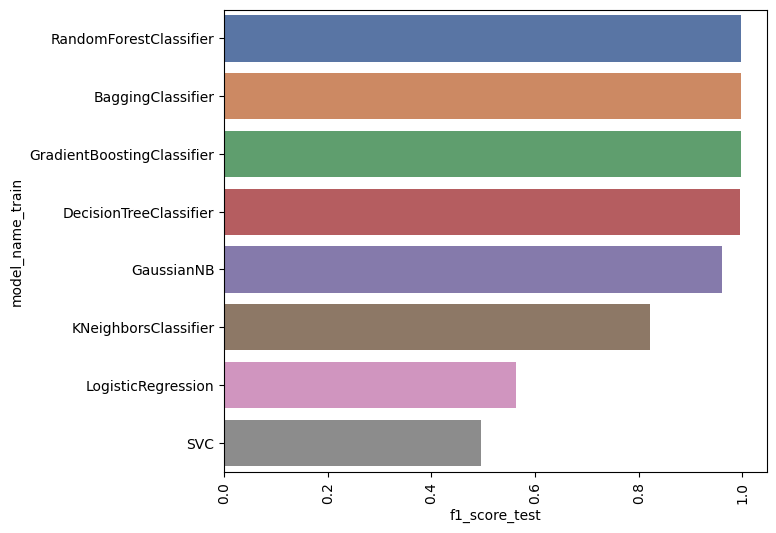

In [149]:
plt.figure(figsize=(7,6))
sns.barplot(y=summary['model_name_train'],x=summary['f1_score_test'],palette='deep')
plt.xticks(rotation=90)
plt.show()


**model selection for task 1**

*  from the above graph it is found that the `bagging_classifier`,`gradiant boosting` performing well compared to other algorithms
* and it is performing well above 95 percentage so not using `optimization techniques` separatly

* im considering the `gradiant boosting` model over `bagging_classifier` as it performing better in more number of times compared to baggining classifer

* will create the `gradiant boosting` model for further use

In [150]:
#model creation
#model initialization
high_priority_model = GradientBoostingClassifier()

high_priority_model.fit(X_train,y_train)

high_priority_pred=high_priority_model.predict(X_test)

In [151]:
#printing the confusion metrics and classification report
print('metrics on test data')
print('confusion matrix')
print(confusion_matrix(y_test,high_priority_pred))
print('\n')
print('classification report')
print(classification_report(y_test,high_priority_pred))
print('==='*10)

metrics on test data
confusion matrix
[[13772     0]
 [    2   208]]


classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13772
           1       1.00      0.99      1.00       210

    accuracy                           1.00     13982
   macro avg       1.00      1.00      1.00     13982
weighted avg       1.00      1.00      1.00     13982



In [152]:
# Save the model
with open('F:\ITSM\high_priority_model.pkl', 'wb') as file:
    pickle.dump(high_priority_model, file)

# TASK-2 | FORECASTING
**Forecast the incident volume in different fields , quarterly and
annual. So that they can be better prepared with resources and
technology planning.**

In [153]:
data_1=df.copy()

In [154]:
data_1.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,No_of_Related_Interactions,No_of_Related_Incidents,No_of_Related_Changes,Handle_Time_hrs_conv
0,11,57,162,0,4,4,4,0.601292,1,553,26,2012-05-02 13:32:00,2013-04-11 13:50:00,2013-04-11 13:51:00,1,2,0,8256.316667
1,1,57,88,0,3,3,3,0.415050,1,611,33,2012-12-03 15:44:00,2013-02-12 12:36:00,2013-02-12 12:36:00,1,1,0,1700.866667
2,1,10,92,0,4,3,4,0.517551,3,339,3,2012-03-29 12:36:00,2014-01-13 15:12:00,2014-01-13 15:13:00,1,0,0,15722.616667
3,1,57,88,0,4,4,4,0.642927,1,611,13,2012-07-17 11:49:00,2013-11-14 09:31:00,2013-11-14 09:31:00,1,0,0,11637.700000
4,1,57,88,0,4,4,4,0.345258,1,611,2,2012-10-08 11:01:00,2013-08-11 13:55:00,2013-08-11 13:55:00,1,0,0,7370.900000


In [155]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46605 entries, 0 to 46605
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   CI_Cat                      46605 non-null  int32         
 1   CI_Subcat                   46605 non-null  int32         
 2   WBS                         46605 non-null  int32         
 3   Status                      46605 non-null  int32         
 4   Impact                      46605 non-null  int32         
 5   Urgency                     46605 non-null  int32         
 6   Priority                    46605 non-null  int32         
 7   number_cnt                  46605 non-null  float64       
 8   Category                    46605 non-null  int32         
 9   KB_number                   46605 non-null  int32         
 10  No_of_Reassignments         46605 non-null  int32         
 11  Open_Time                   46605 non-null  datetime64

*  **sorting the data based on the ticket opening time**

In [156]:
timeseries_data=data_1.sort_values('Open_Time')

In [157]:
timeseries_data.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,No_of_Related_Interactions,No_of_Related_Incidents,No_of_Related_Changes,Handle_Time_hrs_conv
11,1,57,88,0,4,4,4,0.291928,1,611,8,2012-01-10 10:49:00,2013-08-11 14:18:00,2013-08-11 14:22:00,1,0,0,13899.550000
12,1,57,55,0,4,4,4,0.776486,1,401,5,2012-02-10 12:12:00,2014-04-02 09:38:00,2014-04-02 09:38:00,2,0,0,18765.433333
9,1,57,55,0,4,4,4,0.306670,1,401,2,2012-03-09 16:04:00,2013-08-11 14:33:00,2013-08-11 14:35:00,1,0,0,12478.516667
2,1,10,92,0,4,3,4,0.517551,3,339,3,2012-03-29 12:36:00,2014-01-13 15:12:00,2014-01-13 15:13:00,1,0,0,15722.616667
0,11,57,162,0,4,4,4,0.601292,1,553,26,2012-05-02 13:32:00,2013-04-11 13:50:00,2013-04-11 13:51:00,1,2,0,8256.316667


*  as each time a single ticket raised from each department
* taking only CI_Cat column along with open_time
* will also consider only date neglecting the time in the timestamp
---

In [158]:
forecast_data=timeseries_data[['CI_Cat','Open_Time']]

In [159]:
forecast_data['Open_Time']=forecast_data['Open_Time'].dt.date

In [160]:
forecast_data.head()

,CI_Cat,Open_Time
11,1,2012-01-10
12,1,2012-02-10
9,1,2012-03-09
2,1,2012-03-29
0,11,2012-05-02


* **grouping is doing through the concept of pivot_table**

In [161]:
pivot_table = forecast_data.pivot_table(index='Open_Time', columns='CI_Cat', aggfunc='size')

In [162]:
pd.set_option('display.max_rows',None)

In [163]:
pivot_table

CI_Cat,0,1,2,3,4,5,6,7,8,9,10,11
Open_Time,,,,,,,,,,,,
2012-01-10,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-02-10,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-09,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-03-29,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-05-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2012-05-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2012-07-12,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-07-17,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-08-15,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*  converting the pivot table to dataframe

In [164]:
final_df=pd.DataFrame(pivot_table)

* converting the index format from object type to datetime format

In [165]:
final_df.index=pd.to_datetime(final_df.index)


* filling the null values with 0

In [166]:
final_df.fillna(0,inplace=True)

In [167]:
len(final_df)

331

* resampling the data on day
* converting the daily data to quaterly year data

In [168]:
daily_data = final_df.resample('D', closed='right', label='right').asfreq()

In [169]:
quaterly_data = daily_data.resample('Q').sum()

In [170]:
quaterly_data

CI_Cat,0,1,2,3,4,5,6,7,8,9,10,11
Open_Time,,,,,,,,,,,,
2012-03-31,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2012-09-30,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012-12-31,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2013-03-31,0.0,1751.0,0.0,206.0,4.0,8.0,21.0,6.0,5.0,21.0,31.0,408.0
2013-06-30,0.0,2044.0,2.0,215.0,4.0,20.0,12.0,5.0,14.0,17.0,51.0,433.0
2013-09-30,0.0,2363.0,0.0,267.0,7.0,17.0,16.0,7.0,9.0,13.0,27.0,449.0
2013-12-31,1.0,11496.0,3.0,1392.0,38.0,75.0,90.0,40.0,63.0,102.0,220.0,2633.0
2014-03-31,1.0,10538.0,0.0,1052.0,104.0,61.0,162.0,27.0,42.0,122.0,255.0,2671.0


In [171]:
quaterly_data.shape

(12, 12)

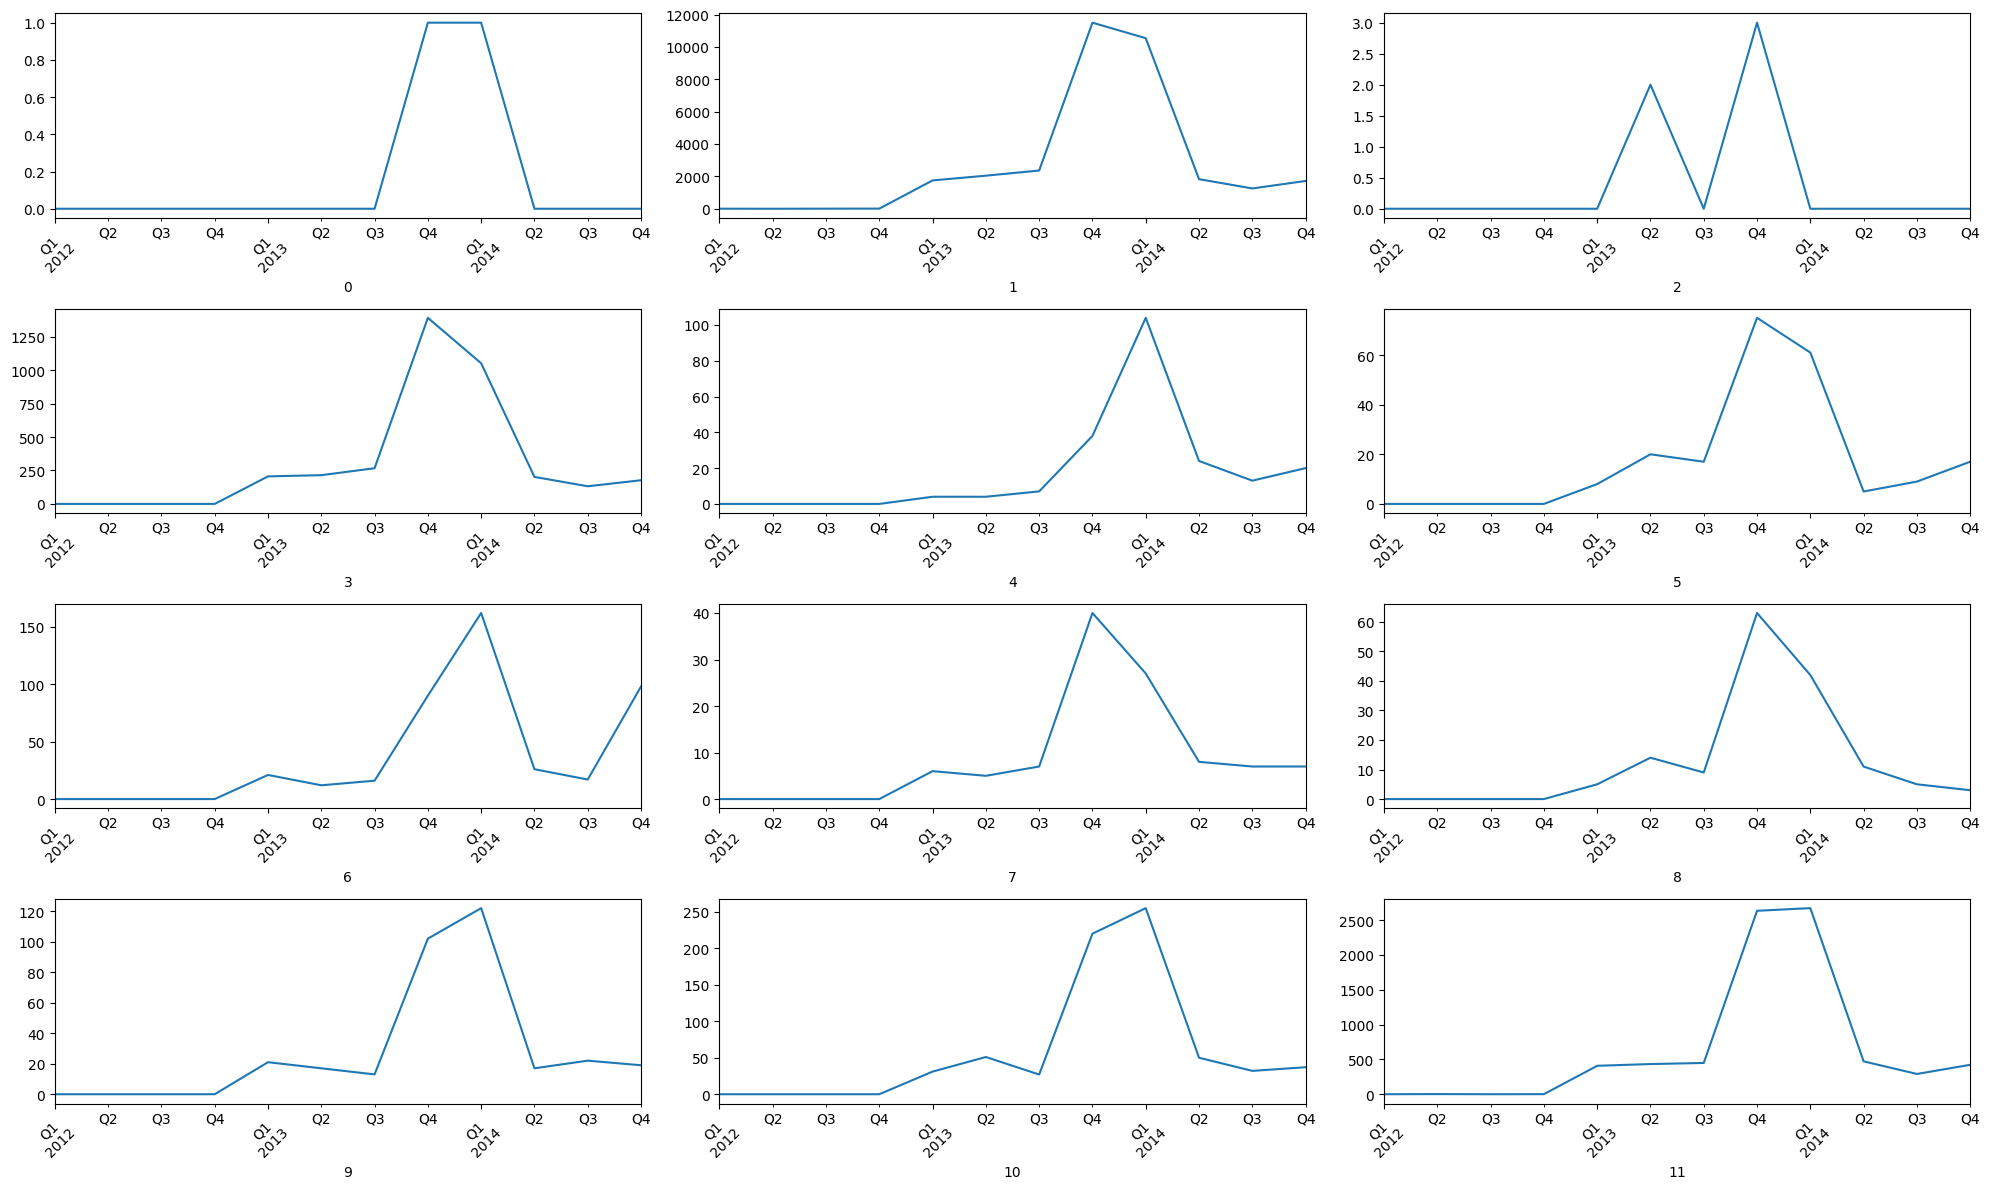

In [172]:
plt.figure(figsize=(20,12))
pl_no=1
for i in quaterly_data.columns:
    plt.subplot(4,3,pl_no)
    quaterly_data[i].plot()
    plt.xlabel(i)
    plt.xticks(rotation=45)
    pl_no+=1
plt.tight_layout()

* all the columns are having the little sudden trend at some time
* and there is no seasonality found the data
* tried eliminating the trend with exponetial smootheing method but its resulting in very bad forecasting

# Arima model

##arima model forecasts and forecast plots

In [173]:
#  Perform the forecasting for each column
arima_forecast = pd.DataFrame()
steps = 12
for column in quaterly_data.columns:
    model = ARIMA(quaterly_data[column], order=(1, 0, 0))  # ARIMA(1, 0, 0) model
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    arima_forecast[column] = forecast


In [174]:
arima_forecast=arima_forecast.astype(int)

In [175]:
arima_forecast

,0,1,2,3,4,5,6,7,8,9,10,11
2015-03-31,0,2249,0,229,18,16,57,7,7,22,46,510
2015-06-30,0,2507,0,253,17,16,44,7,9,24,50,553
2015-09-30,0,2632,0,265,17,16,39,8,10,25,52,573
2015-12-31,0,2693,0,270,17,16,38,8,11,25,52,582
2016-03-31,0,2723,0,273,17,16,37,8,11,25,53,587
2016-06-30,0,2737,0,274,17,16,37,8,11,25,53,589
2016-09-30,0,2744,0,275,17,16,37,8,11,25,53,590
2016-12-31,0,2747,0,275,17,16,37,8,11,25,53,590
2017-03-31,0,2749,0,275,17,16,37,8,11,25,53,591
2017-06-30,0,2750,0,275,17,16,37,8,11,25,53,591


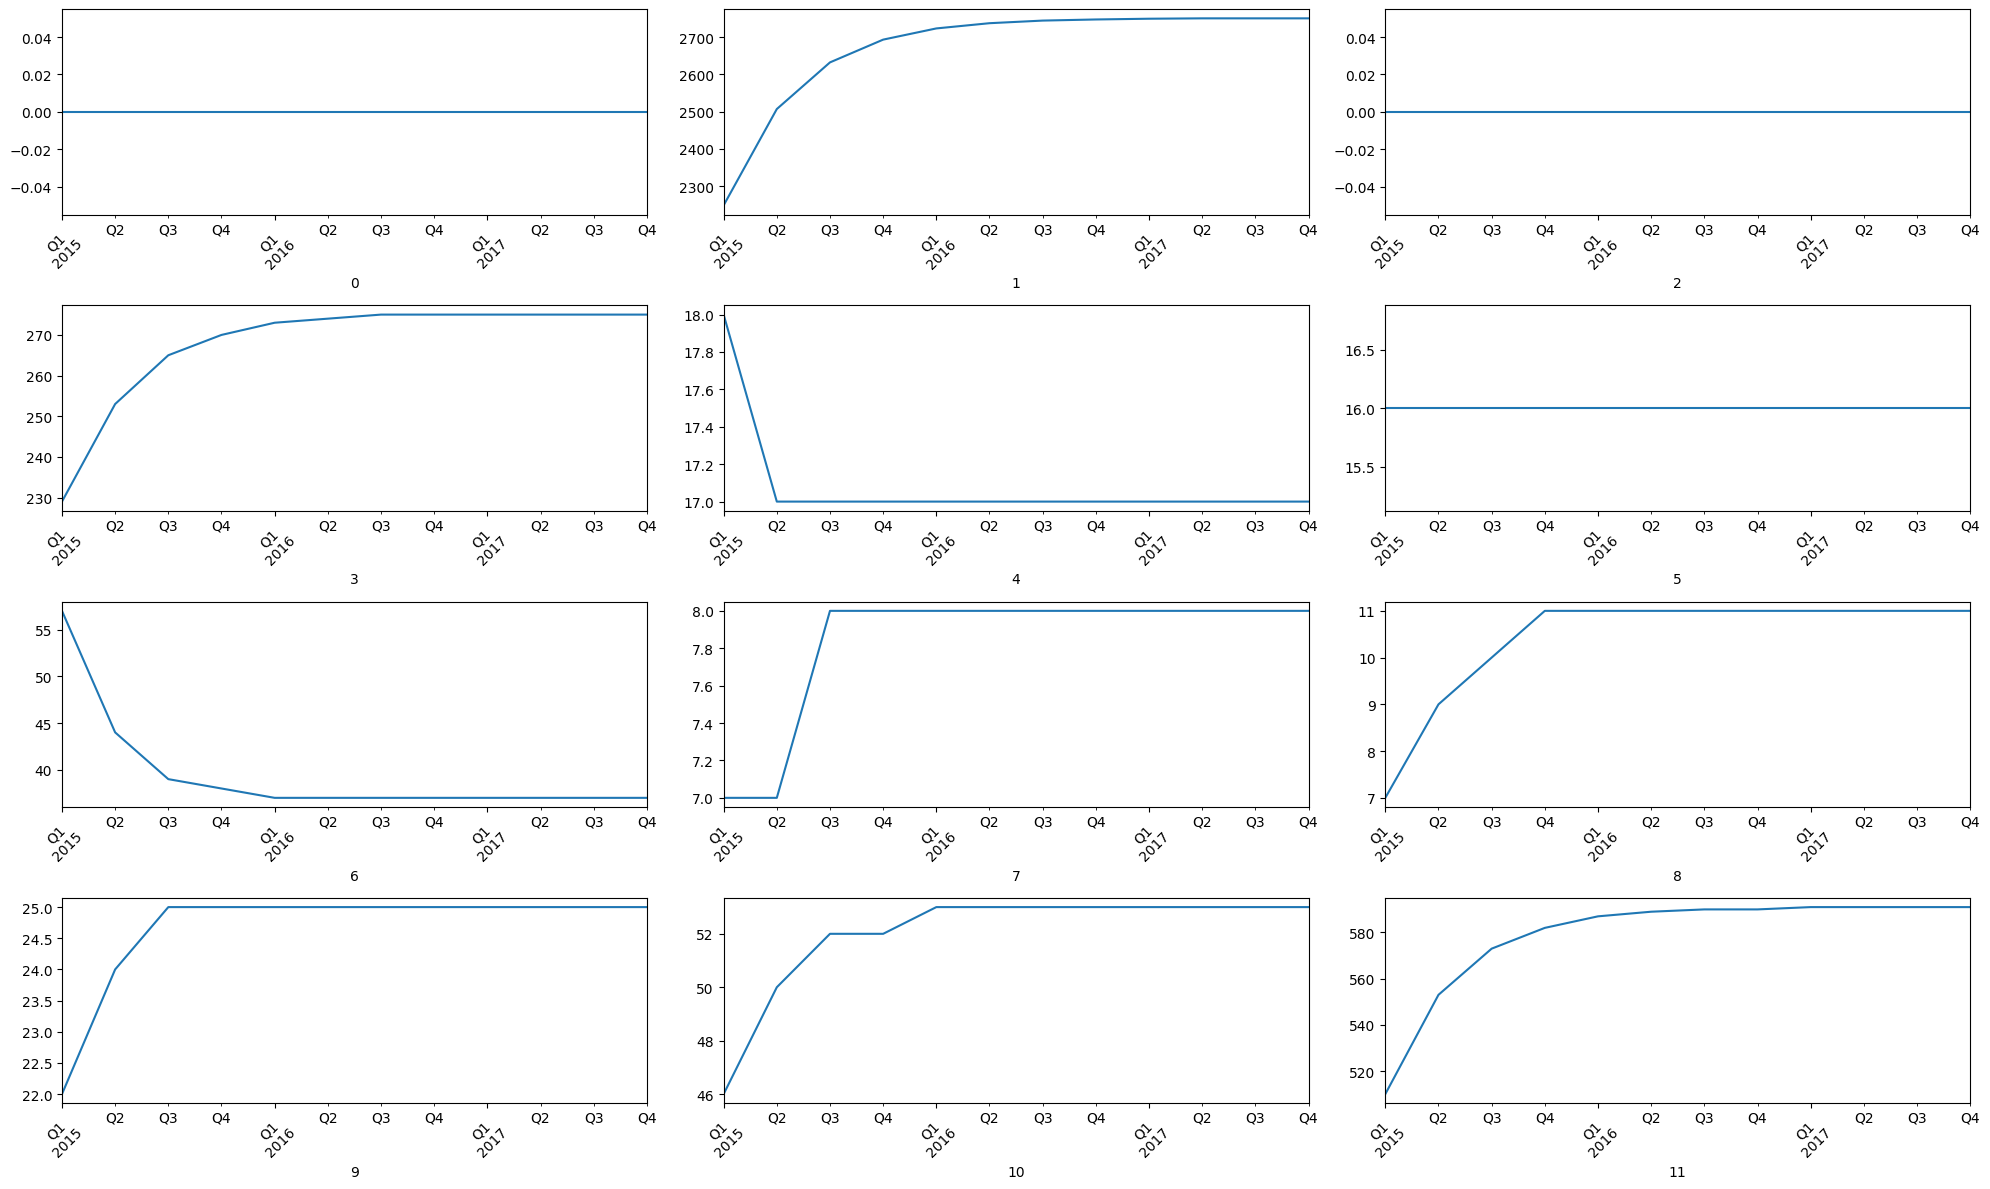

In [176]:
plt.figure(figsize=(20,12))
pl_no=1
for i in arima_forecast.columns:
    plt.subplot(4,3,pl_no)
    arima_forecast[i].plot()
    plt.xlabel(i)
    plt.xticks(rotation=45)
    pl_no+=1
plt.tight_layout()

# Sarimax model

In [177]:
columns_to_forecast = quaterly_data.columns

# Perform the forecasting for each column
sarima_forecast = pd.DataFrame(columns=columns_to_forecast)
for column in columns_to_forecast:
    model = SARIMAX(quaterly_data[column], order=(1, 0, 0), seasonal_order=(1, 0, 0, 12))  # SARIMAX(1, 0, 0)(1, 0, 0, 12) model
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=12)  # Forecast for the next 12 months
    sarima_forecast[column] = forecast

In [178]:
sarima_forecast=sarima_forecast.astype(int)

In [179]:
sarima_forecast

CI_Cat,0,1,2,3,4,5,6,7,8,9,10,11
2015-03-31,0,1097,0,3,0,0,55,0,0,0,0,9
2015-06-30,0,701,0,2,0,0,31,0,0,0,0,4
2015-09-30,0,448,0,1,0,0,18,0,0,0,0,4
2015-12-31,0,286,0,1,0,0,10,0,0,0,0,1
2016-03-31,0,169,0,-203,-3,-7,5,-5,-4,-20,-30,-402
2016-06-30,0,101,0,-212,-3,-19,3,-4,-13,-16,-50,-427
2016-09-30,0,56,0,-264,-6,-16,1,-6,-8,-12,-26,-443
2016-12-31,0,-40,0,-1380,-37,-74,0,-39,-62,-101,-218,-2607
2017-03-31,0,-50,0,-1042,-102,-60,0,-26,-41,-121,-252,-2644
2017-06-30,0,5,0,-200,-23,-4,0,-7,-10,-16,-49,-467


**about forecast models**
*  created 2 forecasting models for predicting the volumns quaterly and annualy
*  out of `arima_model` and `sarima_model` ,arima model performingvery well in forecasting and i plotted the results above.

# TASK 3
 Auto tag the tickets with right priorities and right departments so that reassigning and related delay can be reduced

In [180]:
data_3=df.copy()

In [181]:
data_3.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,No_of_Related_Interactions,No_of_Related_Incidents,No_of_Related_Changes,Handle_Time_hrs_conv
0,11,57,162,0,4,4,4,0.601292,1,553,26,2012-05-02 13:32:00,2013-04-11 13:50:00,2013-04-11 13:51:00,1,2,0,8256.316667
1,1,57,88,0,3,3,3,0.415050,1,611,33,2012-12-03 15:44:00,2013-02-12 12:36:00,2013-02-12 12:36:00,1,1,0,1700.866667
2,1,10,92,0,4,3,4,0.517551,3,339,3,2012-03-29 12:36:00,2014-01-13 15:12:00,2014-01-13 15:13:00,1,0,0,15722.616667
3,1,57,88,0,4,4,4,0.642927,1,611,13,2012-07-17 11:49:00,2013-11-14 09:31:00,2013-11-14 09:31:00,1,0,0,11637.700000
4,1,57,88,0,4,4,4,0.345258,1,611,2,2012-10-08 11:01:00,2013-08-11 13:55:00,2013-08-11 13:55:00,1,0,0,7370.900000


In [182]:
data_3=data_3.drop(['Open_Time','Resolved_Time','Close_Time'],axis=1)

In [183]:
X1=data_3.drop(['Priority','CI_Cat','Urgency'],axis=1)

In [184]:
X1.head()

,CI_Subcat,WBS,Status,Impact,number_cnt,Category,KB_number,No_of_Reassignments,No_of_Related_Interactions,No_of_Related_Incidents,No_of_Related_Changes,Handle_Time_hrs_conv
0,57,162,0,4,0.601292,1,553,26,1,2,0,8256.316667
1,57,88,0,3,0.415050,1,611,33,1,1,0,1700.866667
2,10,92,0,4,0.517551,3,339,3,1,0,0,15722.616667
3,57,88,0,4,0.642927,1,611,13,1,0,0,11637.700000
4,57,88,0,4,0.345258,1,611,2,1,0,0,7370.900000


In [185]:
y1=data_3['Priority']

In [186]:
y1.head()

0    4
1    3
2    4
3    4
4    4
Name: Priority, dtype: int32

In [187]:
y2=data_3['CI_Cat']

# Function for model selection Task 3

##Logic behind the function

 1. first creating a dictionary with the name model_summary and initiating with null values with proper keys
 2. function called `model_selection` will take model as parameter
 3. initially the model will be `initiated` within the function and will be `stored in the variable called model`
 4. model will be `fitted on x_train and y_train`
 5. model will `first predict on test data`
 6. after prediction all the evaluation  `metric values will be appended to dictionary` with corresponding key values.
 7. then it will `print the confusion matrix and classification report` of that model
 8. the same `steps will also the performed` on train data


In [188]:
model_summary_1={'model_name_train':[],'f1_score_train':[],'recall_score_train':[],'accuracy_score_train':[],
               'model_name_test':[],'f1_score_test':[],'recall_score_test':[],'accuracy_score_test':[]}


def model_selction_2(model):

    #model initialization ,fitting and predicting
    print(model)
    model=model()
    model.fit(X_train,y_train)
    model_pred=model.predict(X_test)

    #appending the metrics to the dictionary created
    model_summary_1['model_name_test'].append(model.__class__.__name__)
    model_summary_1['f1_score_test'].append(f1_score(y_test,model_pred,average='macro'))
    model_summary_1['recall_score_test'].append(recall_score(y_test,model_pred,average='macro'))
    model_summary_1['accuracy_score_test'].append(accuracy_score(y_test,model_pred))

    #printing the confusion metrics and classification report
    print('metrics on test data')
    print(confusion_matrix(y_test,model_pred))
    print('\n')
    print(classification_report(y_test,model_pred))

    #predictions on train data
    model_pred1=model.predict(X_train)

    #appending the metrics to the dictionary created
    model_summary_1['model_name_train'].append(model.__class__.__name__)
    model_summary_1['f1_score_train'].append(f1_score(y_train,model_pred1,average='macro'))
    model_summary_1['recall_score_train'].append(recall_score(y_train,model_pred1,average='macro'))
    model_summary_1['accuracy_score_train'].append(accuracy_score(y_train,model_pred1))

    #printing the confusion metrics and classification report
    print('metrics on train data')
    print(confusion_matrix(y_train,model_pred1))
    print('\n')
    print(classification_report(y_train,model_pred1))
    print('==='*10)

In [189]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=42,stratify=y1)

In [190]:
for i in models:
    model_selction_2(i)

<class 'sklearn.linear_model._logistic.LogisticRegression'>
metrics on test data
[[   0    0    0    1    0]
 [   0    0  123   71   15]
 [   0    0  127 1314  156]
 [   0    0  260 6270  699]
 [   0    0   17 4289  640]]


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00       209
           3       0.24      0.08      0.12      1597
           4       0.52      0.87      0.65      7229
           5       0.42      0.13      0.20      4946

    accuracy                           0.50     13982
   macro avg       0.24      0.22      0.19     13982
weighted avg       0.45      0.50      0.42     13982

metrics on train data
[[    0     0     0     1     1]
 [    0     0   270   169    49]
 [    0     0   294  3063   369]
 [    0     0   638 14571  1659]
 [    0     0    49 10017  1473]]


              precision    recall  f1-score   support

           1       0.00      0.00      0.0

In [191]:
summary_1=pd.DataFrame(model_summary_1).sort_values('f1_score_test',ascending=False).drop('model_name_test',axis=1)

In [192]:
summary_1

,model_name_train,f1_score_train,recall_score_train,accuracy_score_train,f1_score_test,recall_score_test,accuracy_score_test
7,GradientBoostingClassifier,0.998373,0.998035,0.997732,0.994573,0.993152,0.994493
3,BaggingClassifier,0.999513,0.999346,0.999663,0.994001,0.993240,0.995280
1,DecisionTreeClassifier,1.000000,1.000000,1.000000,0.992869,0.992518,0.993778
2,RandomForestClassifier,1.000000,1.000000,1.000000,0.794689,0.793026,0.995280
5,GaussianNB,0.986671,0.989267,0.990467,0.784543,0.784756,0.990059
4,KNeighborsClassifier,0.653381,0.644447,0.866168,0.586188,0.578583,0.800315
6,SVC,0.230016,0.248260,0.579990,0.230631,0.248793,0.580532
0,LogisticRegression,0.193096,0.214077,0.500812,0.194372,0.215252,0.503290


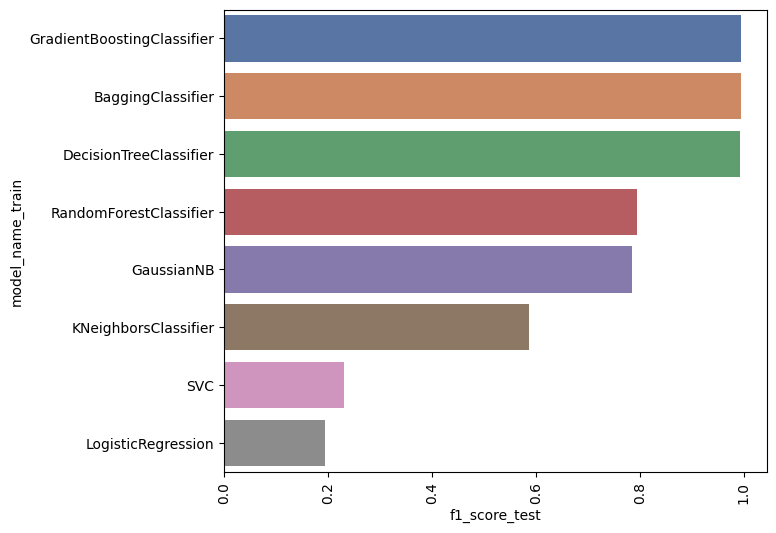

In [193]:
plt.figure(figsize=(7,6))
sns.barplot(y=summary_1['model_name_train'],x=summary_1['f1_score_test'],palette='deep')
plt.xticks(rotation=90)
plt.show()

In [194]:
#model creation
#model initialization
all_priority_model=GradientBoostingClassifier()

#fitting the model
all_priority_model.fit(X_train,y_train)

#predicting using the model
all_priority_pred=all_priority_model.predict(X_test)

#printing the confusion metrics and classification report
print('metrics on test data')
print('confusion matrix')
print(confusion_matrix(y_test,all_priority_pred))
print('\n')
print('classification report')
print(classification_report(y_test,all_priority_pred))
print('==='*10)

metrics on test data
confusion matrix
[[   1    0    0    0    0]
 [   0  207    2    0    0]
 [   0    0 1569   26    2]
 [   0    0    9 7192   28]
 [   0    0    4    6 4936]]


classification report
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       1.00      0.99      1.00       209
           3       0.99      0.98      0.99      1597
           4       1.00      0.99      1.00      7229
           5       0.99      1.00      1.00      4946

    accuracy                           0.99     13982
   macro avg       1.00      0.99      0.99     13982
weighted avg       0.99      0.99      0.99     13982



In [195]:
# Save the model
with open('F:\\ITSM\\all_priority_model.pkl', 'wb') as file:
       pickle.dump(all_priority_model, file)

## Logic behind the function





 1. first creating a dictionary with the name model_summary and initiating with null values with proper keys
 2. function called `model_selection` will take model as parameter
 3. initially the model will be `initiated` within the function and will be `stored in the variable called model`
 4. model will be `fitted on x_train and y_train`
 5. model will `first predict on test data`
 6. after prediction all the evaluation  `metric values will be appended to dictionary` with corresponding key values.
 7. then it will `print the confusion matrix and classification report` of that model
 8. the same `steps will also the performed` on train data


In [196]:
model_summary_3={'model_name_train':[],'f1_score_train':[],'recall_score_train':[],'accuracy_score_train':[],
               'model_name_test':[],'f1_score_test':[],'recall_score_test':[],'accuracy_score_test':[]}


def model_selction_3(model):

    #model initialization ,fitting and predicting
    print(model)
    model=model()
    model.fit(X_train,y_train)
    model_pred=model.predict(X_test)

    #appending the metrics to the dictionary created
    model_summary_3['model_name_test'].append(model.__class__.__name__)
    model_summary_3['f1_score_test'].append(f1_score(y_test,model_pred,average='macro'))
    model_summary_3['recall_score_test'].append(recall_score(y_test,model_pred,average='macro'))
    model_summary_3['accuracy_score_test'].append(accuracy_score(y_test,model_pred))

    #printing the confusion metrics and classification report
    print('metrics on test data')
    print(confusion_matrix(y_test,model_pred))
    print('\n')
    print(classification_report(y_test,model_pred))

    #predictions on train data
    model_pred1=model.predict(X_train)

    #appending the metrics to the dictionary created
    model_summary_3['model_name_train'].append(model.__class__.__name__)
    model_summary_3['f1_score_train'].append(f1_score(y_train,model_pred1,average='macro'))
    model_summary_3['recall_score_train'].append(recall_score(y_train,model_pred1,average='macro'))
    model_summary_3['accuracy_score_train'].append(accuracy_score(y_train,model_pred1))

    #printing the confusion metrics and classification report
    print('metrics on train data')
    print(confusion_matrix(y_train,model_pred1))
    print('\n')
    print(classification_report(y_train,model_pred1))
    print('==='*10)

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X1, y2, test_size=0.3, random_state=42,stratify=y2)

In [198]:
for i in models:
    model_selction_3(i)

<class 'sklearn.linear_model._logistic.LogisticRegression'>
metrics on test data
[[9335    0   41    0    0    0    0    0    0    0  527]
 [   1    0    0    0    0    0    0    0    0    0    0]
 [1079    0   14    0    0    0    0    0    0    0    0]
 [  64    0    0    0    0    0    0    0    0    0    0]
 [  64    0    0    0    0    0    0    0    0    0    0]
 [ 116    0   17    0    0    0    0    0    0    0    0]
 [  32    0    0    0    0    0    0    0    0    0    0]
 [  46    0    0    0    0    0    0    0    0    0    0]
 [  97    0    3    0    0    0    0    0    0    0    0]
 [ 210    0    1    0    0    0    0    0    0    0    0]
 [2266    0    8    0    0    0    0    0    0    0   61]]


              precision    recall  f1-score   support

           1       0.70      0.94      0.80      9903
           2       0.00      0.00      0.00         1
           3       0.17      0.01      0.02      1093
           4       0.00      0.00      0.00        64
       

In [199]:
summary_3=pd.DataFrame(model_summary_3).sort_values('f1_score_test',ascending=False).drop('model_name_test',axis=1)

In [200]:
summary_3

,model_name_train,f1_score_train,recall_score_train,accuracy_score_train,f1_score_test,recall_score_test,accuracy_score_test
1,DecisionTreeClassifier,1.000000,1.000000,1.000000,0.903327,0.900933,0.990202
3,BaggingClassifier,0.971592,0.957656,0.998805,0.899073,0.894853,0.990345
7,GradientBoostingClassifier,0.991558,0.988146,0.977225,0.889628,0.876398,0.976756
2,RandomForestClassifier,1.000000,1.000000,1.000000,0.858084,0.834383,0.975540
4,KNeighborsClassifier,0.688076,0.647983,0.939429,0.684181,0.649042,0.914676
5,GaussianNB,0.446148,0.645900,0.458879,0.389244,0.606401,0.462952
0,LogisticRegression,0.073144,0.082036,0.671888,0.079074,0.089234,0.673008
6,SVC,0.069168,0.083364,0.708365,0.075379,0.090900,0.708196


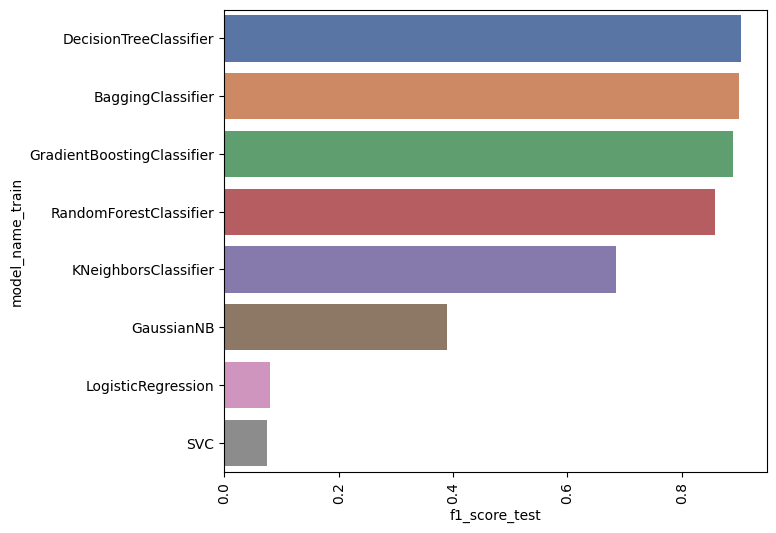

In [201]:
plt.figure(figsize=(7,6))
sns.barplot(y=summary_3['model_name_train'],x=summary_3['f1_score_test'],palette='deep')
plt.xticks(rotation=90)
plt.show()

In [202]:
#model creation
#model initialization
department_classification_model=RandomForestClassifier()

#fitting the model
department_classification_model.fit(X_train,y_train)

#predicting using the model
department_classification_pred=department_classification_model.predict(X_test)

#printing the confusion metrics and classification report
print('metrics on test data')
print('confusion matrix')
print(confusion_matrix(y_test,department_classification_pred))
print('\n')
print('classification report')
print(classification_report(y_test,department_classification_pred))
print('==='*10)

metrics on test data
confusion matrix
[[9812    0    0    0    0    0    0    0    0    0   91]
 [   0    0    1    0    0    0    0    0    0    0    0]
 [  11    0 1082    0    0    0    0    0    0    0    0]
 [   1    0    0   63    0    0    0    0    0    0    0]
 [   0    0    1    0   63    0    0    0    0    0    0]
 [   3    0    7    0    0  122    0    0    0    1    0]
 [  10    0    3    0    1    1   16    0    1    0    0]
 [   0    0    0    0    0    0    0   46    0    0    0]
 [   3    0    0    0    0    0    0    0   97    0    0]
 [   1    0    1    0    0    2    0    0    0  207    0]
 [ 217    0    0    0    0    0    0    0    0    0 2118]]


classification report
              precision    recall  f1-score   support

           1       0.98      0.99      0.98      9903
           2       0.00      0.00      0.00         1
           3       0.99      0.99      0.99      1093
           4       1.00      0.98      0.99        64
           5       0.98     

In [203]:
# Save the model
with open('F:\\ITSM\\department_classification_model.pkl', 'wb') as file:
       pickle.dump(department_classification_model, file)

## task 4. Predicting Request For Change (RFC)

In [204]:
data_4=df.copy()

In [205]:
data_4.head()

,CI_Cat,CI_Subcat,WBS,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,No_of_Reassignments,Open_Time,Resolved_Time,Close_Time,No_of_Related_Interactions,No_of_Related_Incidents,No_of_Related_Changes,Handle_Time_hrs_conv
0,11,57,162,0,4,4,4,0.601292,1,553,26,2012-05-02 13:32:00,2013-04-11 13:50:00,2013-04-11 13:51:00,1,2,0,8256.316667
1,1,57,88,0,3,3,3,0.415050,1,611,33,2012-12-03 15:44:00,2013-02-12 12:36:00,2013-02-12 12:36:00,1,1,0,1700.866667
2,1,10,92,0,4,3,4,0.517551,3,339,3,2012-03-29 12:36:00,2014-01-13 15:12:00,2014-01-13 15:13:00,1,0,0,15722.616667
3,1,57,88,0,4,4,4,0.642927,1,611,13,2012-07-17 11:49:00,2013-11-14 09:31:00,2013-11-14 09:31:00,1,0,0,11637.700000
4,1,57,88,0,4,4,4,0.345258,1,611,2,2012-10-08 11:01:00,2013-08-11 13:55:00,2013-08-11 13:55:00,1,0,0,7370.900000


In [206]:
# Selecting the predictors
X1 = data_4.loc[:,['CI_Subcat','WBS','Priority','Category','No_of_Related_Interactions','No_of_Related_Incidents']]
y1 = data_4['No_of_Related_Changes']

In [207]:
X1.head(2)

,CI_Subcat,WBS,Priority,Category,No_of_Related_Interactions,No_of_Related_Incidents
0,57,162,4,1,1,2
1,57,88,3,1,1,1


In [209]:
encoder=LabelEncoder()
for i in (0,1,3,4):
    X1.iloc[:,i] = encoder.fit_transform(X1.iloc[:,i])

In [210]:
# Splitting into train and test for calculating the accuracy
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y1,test_size=0.3,random_state=10)

In [213]:
# Standardization technique is used
sc = StandardScaler()
X1_train = sc.fit_transform(X1_train)
X1_test = sc.transform(X1_test)

In [214]:
X1_train.shape

(32623, 6)

In [215]:
X1_test.shape

(13982, 6)

##  Models

### 1. Decision Tree

In [216]:
# Training the model
from sklearn.tree import DecisionTreeClassifier
model1_dtree=DecisionTreeClassifier()
model1_dtree.fit(X1_train,y1_train)

DecisionTreeClassifier()

In [217]:
# Predicting the model
y1_predict_dtree = model1_dtree.predict(X1_test)

In [218]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y1_test,y1_predict_dtree))
print(classification_report(y1_test,y1_predict_dtree))

0.9886997568302103
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     13834
           1       0.28      0.04      0.06       138
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         0

    accuracy                           0.99     13982
   macro avg       0.25      0.21      0.21     13982
weighted avg       0.98      0.99      0.98     13982



In [219]:
confusion_matrix(y1_test,y1_predict_dtree)

array([[13819,    13,     1,     0,     1],
       [  132,     5,     1,     0,     0],
       [    9,     0,     0,     0,     0],
       [    1,     0,     0,     0,     0],
       [    0,     0,     0,     0,     0]], dtype=int64)

## 2 Random Forest

In [220]:
# Training the model
from sklearn.ensemble import RandomForestClassifier
model1_rf = RandomForestClassifier()
model1_rf.fit(X1_train,y1_train)

RandomForestClassifier()

In [221]:
# Predicting the model
y1_predict_rf = model1_rf.predict(X1_test)

In [222]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y1_test,y1_predict_rf))
print(classification_report(y1_test,y1_predict_rf))

0.9891288799885567
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     13834
           1       0.33      0.03      0.05       138
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00         1

    accuracy                           0.99     13982
   macro avg       0.33      0.26      0.26     13982
weighted avg       0.98      0.99      0.98     13982



In [223]:
confusion_matrix(y1_test,y1_predict_rf)

array([[13826,     8,     0,     0],
       [  133,     4,     1,     0],
       [    9,     0,     0,     0],
       [    1,     0,     0,     0]], dtype=int64)

In [228]:
#pip install joblib

In [227]:
# Exporting the trained model
joblib.dump(model1_dtree,'F:\\ITSM\\Predict_RFC.ml')

['F:\\ITSM\\Predict_RFC.ml']